In [1]:
import pandas as pd 
from langchain_cohere import ChatCohere
from langchain_core.messages import AIMessage, HumanMessage
from langchain.chat_models import init_chat_model


In [ ]:
from dotenv import load_dotenv
load_dotenv('.env')


False

In [3]:
model = init_chat_model('gpt-5-nano-2025-08-07')

In [4]:
from langchain.messages import HumanMessage, AIMessage, SystemMessage

conversation = [
    SystemMessage("You are a helpful assistant that translates English to French."),
    HumanMessage("Translate: I love programming."),
    AIMessage("J'adore la programmation."),
    HumanMessage("Translate: I love building applications.")
]

conversation = [
    {"role": "system", "content": "You are a helpful assistant that translates English to French."},
    {"role": "user", "content": "Translate: I love programming."},
    {"role": "assistant", "content": "J'adore la programmation."},
    {"role": "user", "content": "Translate: I love building applications."}
]


response = model.invoke(conversation)
print(response) 



content="J'adore développer des applications." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 463, 'prompt_tokens': 49, 'total_tokens': 512, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D6sbJyHgQF07xENiKm4Mb66420Uqx', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='lc_run--019c3bf1-c073-7692-8c90-01c54010509d-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 49, 'output_tokens': 463, 'total_tokens': 512, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 448}}


In [6]:
from langchain.tools import tool

@tool
def get_weather(location: str) -> str:
    """Get the weather at a location."""
    return f"It's sunny in {location}."

from typing import List

@tool
def add(numbers: List[int]) -> int:
    """Add a list of numbers together."""
    return sum(numbers)

tools = [get_weather,add]

model_with_tools = model.bind_tools(tools)  

conversation = [
    {"role": "system", "content": "You are a helpful assistant that does math. and summarize"},
    {"role": "user", "content": "Add 1000, 3 times"},
]

while True : 
    response = model_with_tools.invoke(conversation)
    conversation.append(response) 

    if not response.tool_calls : break
    for tool_call in response.tool_calls:
        # print(f"Tool: {tool_call['name']}")
        # print(f"Args: {tool_call['args']}")
        func_name = tool_call['name']
        args = tool_call['args']
        ans = eval(func_name).invoke(args)
        conversation.append({"role" : "tool", "tool_call_id" : tool_call['id'] , "content" : str(ans) })

In [7]:
conversation

[{'role': 'system',
  'content': 'You are a helpful assistant that does math. and summarize'},
 {'role': 'user', 'content': 'Add 1000, 3 times'},
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 285, 'prompt_tokens': 169, 'total_tokens': 454, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D6sbbNk8xzqEWch86K1ojKi1xeC2Z', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c3bf2-05b3-7521-ba66-9bd2d2dcf8f6-0', tool_calls=[{'name': 'add', 'args': {'numbers': [1000, 1000, 1000]}, 'id': 'call_y3FFVPWru7NhSplwqrkLnHTx', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 169, 'output_tokens': 2

In [19]:
from langchain.tools import tool
from langchain.agents import create_agent
from pydantic import BaseModel, Field


class MathOutput(BaseModel):
    answer: int = Field(description="The final calculated answer")
    reason: str = Field(description="Explanation of the reason taken")


@tool
def add(numbers: List[int]) -> int:
    """Add a list of numbers together."""
    return sum(numbers)

@tool
def multiply(numbers: List[int]) -> int:
    """Multiplies a list of numbers together."""
    ans = 1
    for n in numbers : ans *= n
    return ans




tools = [add,multiply]
math_agent = create_agent(model, tools=tools,response_format=MathOutput)

conversation = [
    {"role": "system", "content": "You are a helpful assistant that does math. Use the tools that are provided for operations."},
    # {"role": "system", "content": "You are a helpful assistant that does math. Use the tools that are provided for operations and call the format_answer once we have the final answer"},
    {"role": "user", "content": "Add 1000, 3 times. and later mutiply it by 5"},
]
model_output = math_agent.invoke({ "messages"  : conversation})
model_output['structured_response']

MathOutput(answer=15000, reason='First, we added 1000 three times to get 3000. Then we multiplied the result by 5 to obtain 15000.')

In [26]:
import json
json.loads(model_output['structured_response'].model_dump_json())

{'answer': 15000,
 'reason': 'First, we added 1000 three times to get 3000. Then we multiplied the result by 5 to obtain 15000.'}

In [21]:
from langgraph.graph import StateGraph, MessagesState, START, END

def mock_llm(state: MessagesState):
    return {"messages": [{"role": "ai", "content": "hello world"}]}

graph = StateGraph(MessagesState)
graph.add_node(mock_llm)
graph.add_edge(START, "mock_llm")
graph.add_edge("mock_llm", END)
graph = graph.compile()

graph.invoke({"messages": [{"role": "user", "content": "hi!"}]})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='965208a0-d131-4149-a7db-056b55b47e26'),
  AIMessage(content='hello world', additional_kwargs={}, response_metadata={}, id='a04dc828-7b28-4cfa-b14e-de80f88904f9', tool_calls=[], invalid_tool_calls=[])]}

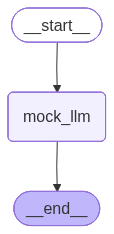

In [22]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

Implement the math bot
- Filesystem for reading the sum or prompt
- Does the math operation
- File system to store the data


In [46]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class MemoryState(TypedDict) : 
    file_path : str
    file_content : str
    save_path : str
    answer : int 
    reason : str
    

def read_file(state : MemoryState) : 
    file_ = open(state['file_path'])
    file_content = file_.read()
    return {'file_content' : file_content} 

def write_file(state : MemoryState) : 
    with open(f'{state['save_path']}/data.json', 'w') as f:
        json.dump(state, f)
    pass



def math_bot(state : MemoryState) :
    
    conversation = [
    {"role": "system", "content": "You are a helpful assistant that does math. and summarize. Use the tools that are provided for operations"},
    {"role": "user", "content": state['file_content']}]
    model_output = math_agent.invoke({"messages" : conversation})
    answer = json.loads(model_output['structured_response'].model_dump_json())
    return answer
    pass 

In [47]:
workflow = StateGraph(MemoryState)

workflow.add_node('read_file',read_file)
workflow.add_node('math_bot',math_bot)
workflow.add_node('write_file',write_file)



In [48]:
workflow.add_edge(START,"read_file")
workflow.add_edge("read_file","math_bot")
workflow.add_edge("math_bot",'write_file')
workflow.add_edge("write_file",END)

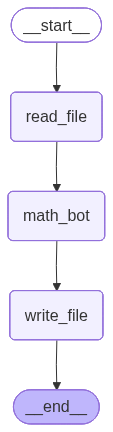

In [49]:
chain = workflow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))


In [50]:
state = chain.invoke({
        "file_path" :  "/run/media/srujan/Data/Development/ML-algo-practice/data/agents/prompt.txt",
        "save_path" : "/run/media/srujan/Data/Development/ML-algo-practice/data/agents/"})

In [51]:
state

{'file_path': '/run/media/srujan/Data/Development/ML-algo-practice/data/agents/prompt.txt',
 'file_content': 'Math Sum : \n\n- add 2+2 and multiply it by 5\n- Add 100 \n- Mulitply by 23',
 'save_path': '/run/media/srujan/Data/Development/ML-algo-practice/data/agents/',
 'answer': 2760,
 'reason': 'Compute: (2+2)=4; 4*5=20; 20+100=120; 120*23=2760.'}